In [1]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternativa
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Usaré **yfinance** para descargar datos de yahoo finance

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats

Usaré los datos de las acciones de **Apple**.

Yo soy creyente de la filosofía de invertir a largo plazo, por lo tanto los datos que se tomarán en cuenta son de un periodo de 10 años

In [13]:
RISKY_ASSET = 'AAPL'
START_DATE = '2012-01-01'
END_DATE = '2022-01-01'

Cargandolos en un data frame de pandas

In [14]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Descargados {df.shape[0]} renglones de datos.')

[*********************100%***********************]  1 of 1 completed
Descargados 2517 renglones de datos.


Mostrando los datos descargados

In [15]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.557467,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.624948,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.765114,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.898558,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.878097,394024400
...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.836319,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.799149,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,178.888916,62348900


Calculando los rendimientos diarios

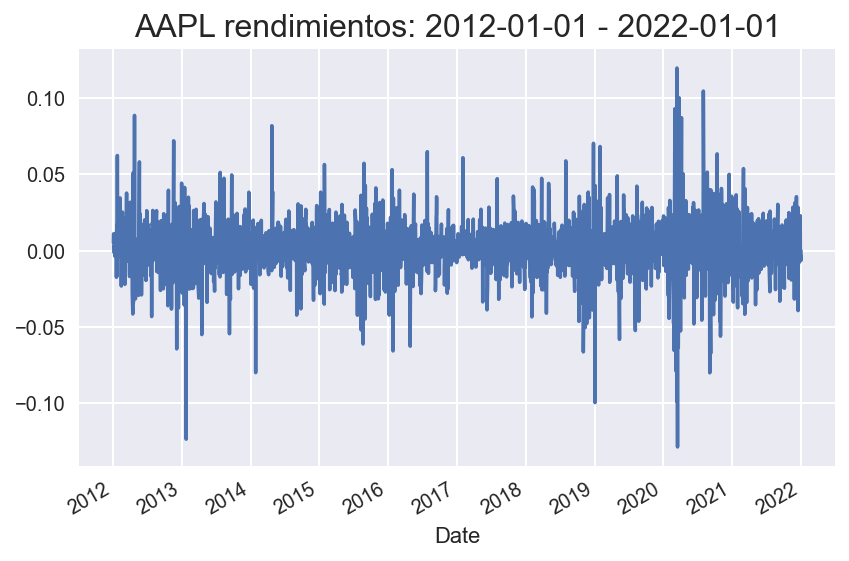

Rendimiento promedio: 0.12%


In [16]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()   

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} rendimientos: {START_DATE} - {END_DATE}', 
             fontsize=16)


plt.tight_layout()
#plt.savefig('imagen1.png')
plt.show()

print(f'Rendimiento promedio: {100 * returns.mean():.2f}%')

Graficamos el histograma para darnos una idea de si realmente siguen una distribución normal o no.

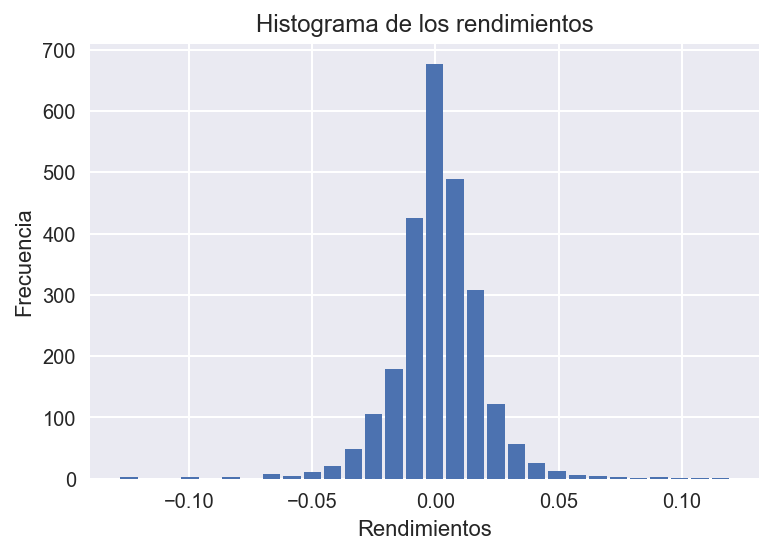

In [17]:
plt.hist(x=returns, rwidth=0.85, bins=30)
plt.title('Histograma de los rendimientos')
plt.xlabel('Rendimientos')
plt.ylabel('Frecuencia')

plt.show()

Es claro que los datos siguen una distribución normal.

## Ahora dividimos el conjunto de datos en dos: un conjunto de entrenamiento y uno de prueba.

Harémos la prueba con 5 grupos

- train: 25% y test: 75%
- train: 50% y test: 50% 
- train: 75% y test: 25%
- train: 20% y test: 80%
- train: 80% y test: 20%

### train: 25% y test: 75%

In [115]:
train = returns['2012-01-01':'2014-05-31']
test = returns['2014-06-01':'2022-01-01']

Definiendo los parámetros de simulación

In [116]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

Comparando la gráfica y el histograma

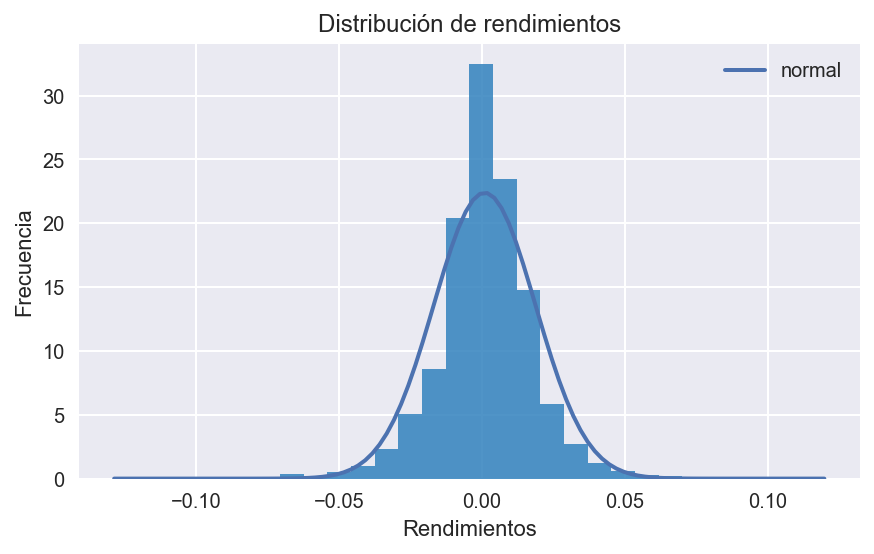

In [117]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

Y la gráfica de cuantiles

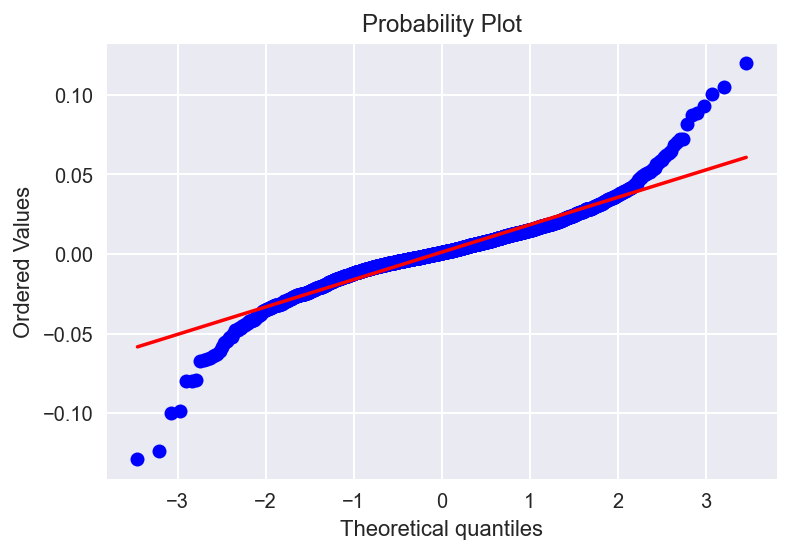

In [118]:
import pylab 
stats.probplot(returns, dist="norm", plot=pylab)
pylab.show()

Haciendo la prueba de kolmogorov

In [119]:
from scipy.stats import kstest
kstest(returns, 'norm', args=(mu, sigma))

KstestResult(statistic=0.08456992739092808, pvalue=4.1977396801525657e-16)

Función de la simulación

In [120]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

Corriendo la simulación y graficando los resultados

In [121]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

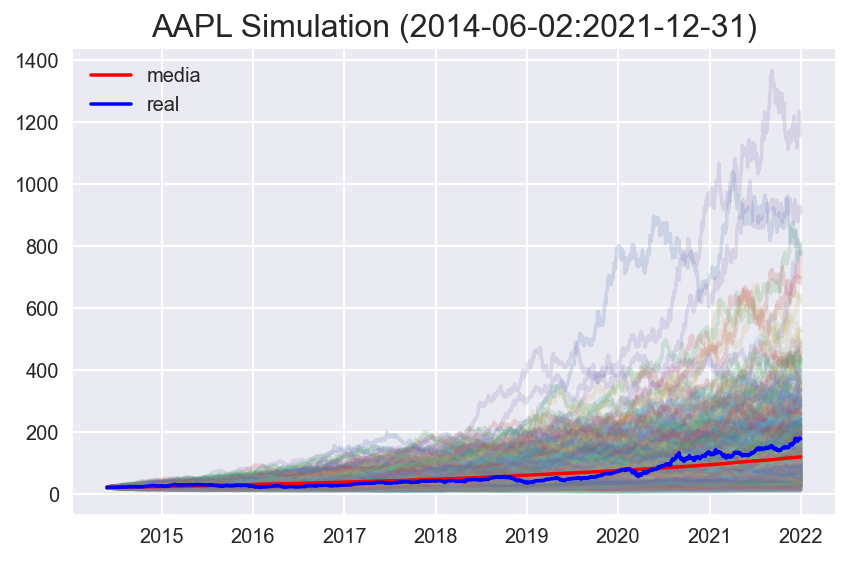

In [122]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

### train: 50% y test: 50%

In [123]:
train = returns['2012-01-01':'2016-12-31']
test = returns['2017-01-01':'2022-01-01']

Definiendo los parámetros de simulación

In [124]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [125]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

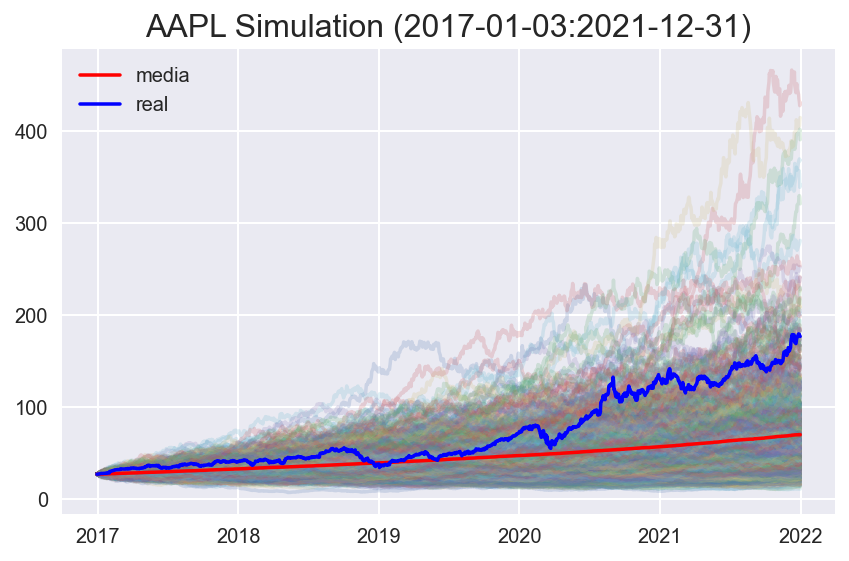

In [126]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

### train: 75% y test: 25%

In [127]:
train = returns['2012-01-01':'2019-05-31']
test = returns['2019-06-01':'2022-01-01']

Definiendo los parámetros de simulación

In [128]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [129]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

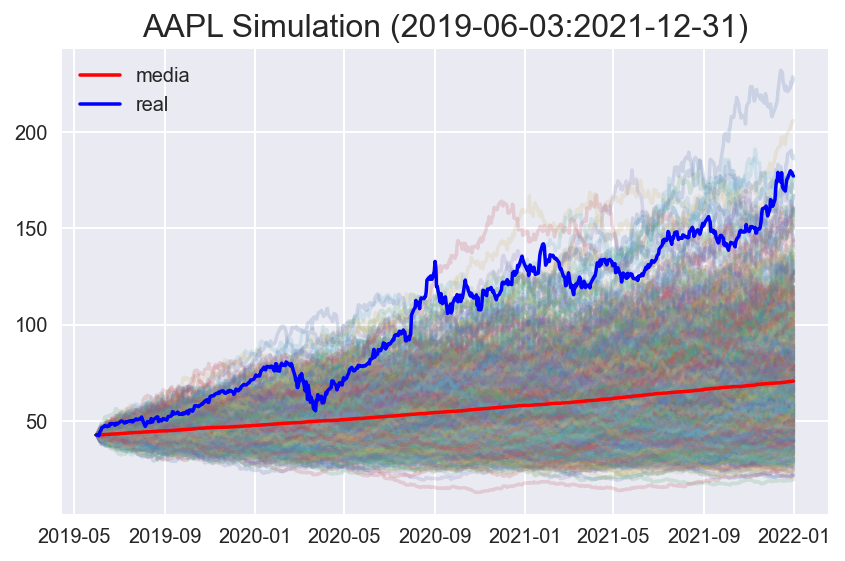

In [130]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

### train: 20% y test: 80%

In [131]:
train = returns['2012-01-01':'2013-12-31']
test = returns['2014-01-01':'2022-01-01']

Definiendo los parámetros de simulación

In [132]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [133]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

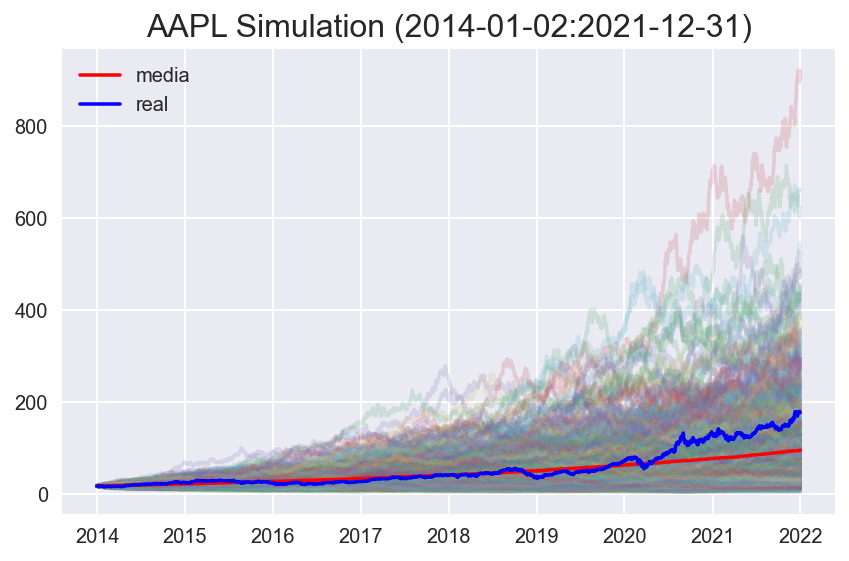

In [134]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

### train: 80% y test: 20%

In [142]:
train = returns['2012-01-01':'2019-12-31']
test = returns['2020-01-01':'2022-01-01']

Definiendo los parámetros de simulación

In [143]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [144]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

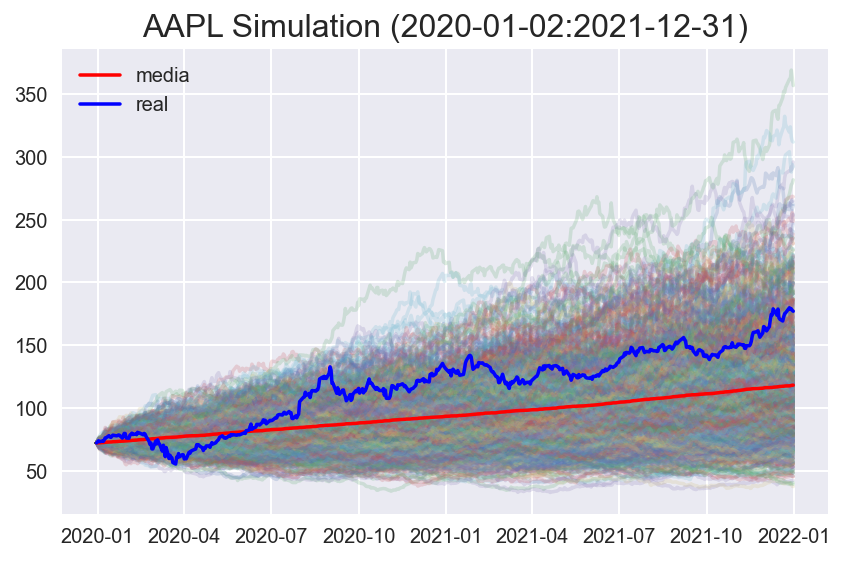

In [145]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

## Conclusión

Me parece que la mejor manera de dividir los datos de entrenamiento y de prueba fueron 25% para entrenamiento y 75% para prueba y ligeramente similar el de 20% para entrenamiento y 80% para prueba, pues la media de las simulaciones calculadas fue más cercana a los precios reales.
Además que el uso de 1000 simulaciones en lugar de 100 vistas en clase ayudó a que la simulación fuese más cercana.